In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# ==============================================================================
# 0. 超参数及全局配置 (保持参数清晰)
# ==============================================================================
# S: Start of decoding input (usually used by TGT_VOCAB)
# E: End of decoding output (usually used by TGT_VOCAB)
# P: Padding token (used by both SRC_VOCAB and TGT_VOCAB)

# Transformer Parameters (使用一个配置字典更规范，但这里保留了变量形式)
# 假设这些在执行前已定义：
# 1:分词 -> 索引化             [I, love, you] → [0, 1, 2] 
# 2:通过 embedding 查表取向量:  E[0] → 向量表示 "I"  E[1] → 向量表示 "love"  E[2] → 向量表示 "you"
SRC_VOCAB = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
TGT_VOCAB = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
SRC_VOCAB_SIZE = len(SRC_VOCAB)  # 源语言词表大小
TGT_VOCAB_SIZE = len(TGT_VOCAB) # 目标语言词表大小
SRC_LEN = 5  # 源句固定长度
TGT_LEN = 5  # 目标句固定长度
D_MODEL = 512  # 词向量维度
D_FF = 2048 # 前馈层维度
D_K = D_V = 64 # 每个注意力头维度
N_LAYERS = 6 # 编码器/解码器层数
N_HEADS = 8 # 注意力头数
PAD_ID = 0 # 约定 Pading Token 的 ID 为 0

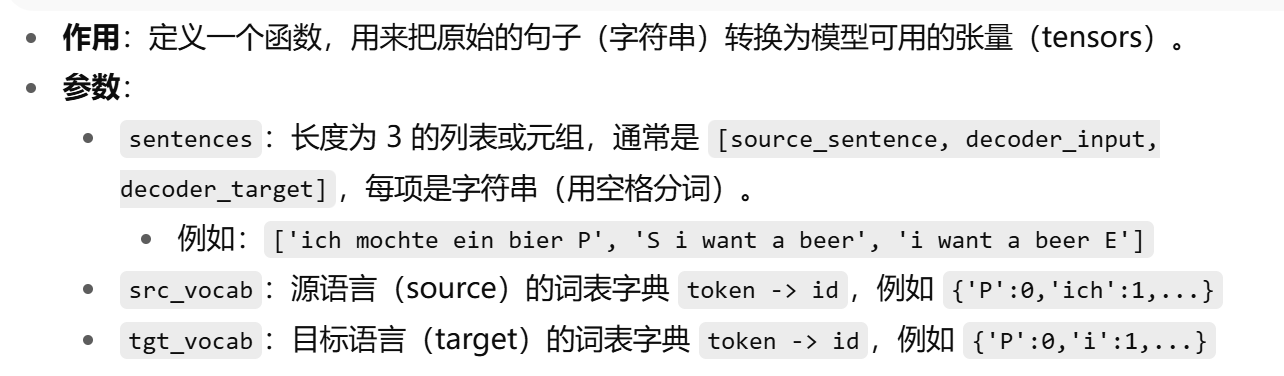

In [2]:
# ==============================================================================
# 1. 辅助函数 (Functions)
# ==============================================================================

def make_batch(sentences, src_vocab, tgt_vocab):# 用来把原始的句子（字符串）转换为模型可用的张量
    """构建批次数据 (保持原逻辑，但传入词汇表)"""
    # 假设 sentences 结构: [source_sentence, decoder_input, decoder_target]
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]] # ['S','i','want','a','beer'] → [5,1,2,3,4] → [[5,1,2,3,4]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch) # LongTensor 等同于 torch.tensor(..., dtype=torch.long)

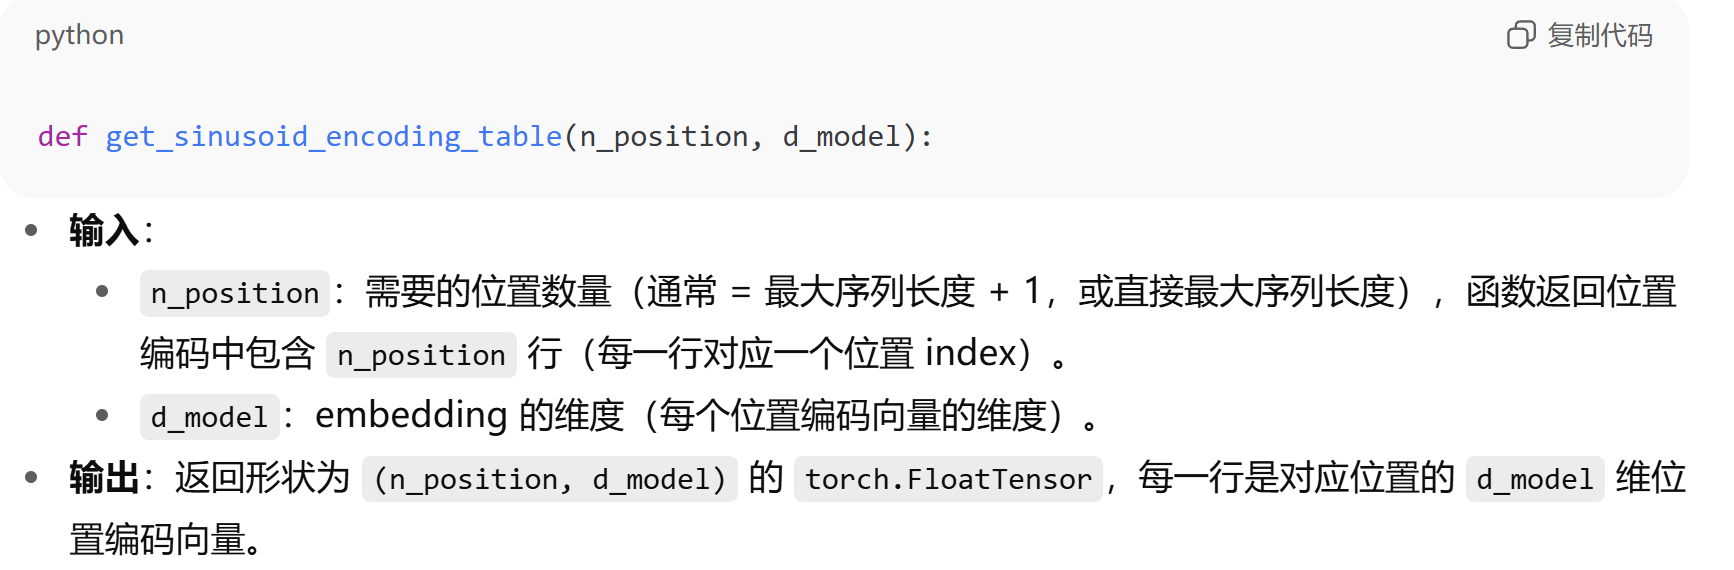

In [3]:
def get_sinusoid_encoding_table(n_position, d_model):
    """生成正弦位置编码表"""
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model) # hid_idx // 2 表示把维度索引 hid_idx 两两分组（偶数维和紧接的奇数维共享同一个频率）
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)] 

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i   # 对于每个维度对 (2i, 2i+1)，使用相同的频率（同一个分母），一个维度取 sin(angle)，另一个取 cos(angle)。
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1  #  也就是说，在同一个embedding向量中，相邻的偶数位置和基数位置的频率x是相同的，只是偶数位置用的是sinx，奇数位置用的是cosx
    return torch.FloatTensor(sinusoid_table)

这个函数生成一个用于注意力（attention）中的 Padding mask，用于屏蔽掉输入中填充（padding）位置，使得注意力计算不会把注意力放到那些无意义的 PAD token 上。

Padding Mask

Transformer 输入的句子通常要补齐到相同长度，比如：

batch = [
  [I, want, beer, PAD, PAD],
  [He, drinks, a, beer, PAD]
]


其中 PAD（padding token）只是为了对齐批次，不代表真实内容。

如果不屏蔽这些 PAD，在注意力计算中它们也会被当成有效词，
会污染注意力分布（比如 Softmax 权重分配到这些空位上），
所以我们需要告诉模型：“这些位置是无意义的，忽略它们”。

✅ Padding Mask 的作用
👉 在注意力中把所有 “PAD” 位置设为 -inf（softmax 后接近 0）。
这样模型不会把注意力放在补齐位置上。

In [4]:
def get_attn_pad_mask(seq_q, seq_k, pad_id):
    """
    生成 Pad Mask (Batch_size x len_q x len_k)
    Pad Mask 值为 True 的位置在计算时会被屏蔽 (masked_fill_时需要反转)
    """
    len_q = seq_q.size(-1) # seq_q 的形状一般为 (B, len_q) 
    #  seq_k 假设形状为 (B, len_k)
    #  seq_k.data.eq(pad_id) 会返回一个布尔（或 byte）张量，形状 (B, len_k)，其中位置为 True 表示该 token 是 PAD（等于 pad_id）。
    # .unsqueeze(1)：在第 1 个维度插入一个维度，将 (B, len_k) 变为 (B, 1, len_k)。这是为了后面扩展到 (B, len_q, len_k)，加上中间的 “len_q 维”。
    pad_attn_mask = seq_k.data.eq(pad_id).unsqueeze(1)  # B x 1 x len_k
    # 扩展到 B x len_q x len_k, 之前得到 pad_attn_mask 为 shape (1,1,4)，len_q=5 → expand → (1,5,4)，即每一行（5 个 query）都有相同 [False,False,True,True] 的 mask。
    return pad_attn_mask.expand(-1, len_q, -1)  

 作用概述

目标：生成一个**“未来不可见”遮罩矩阵（look-ahead mask）**。

使用场景：仅用于 Decoder 的 Self-Attention。

核心功能：保证在解码阶段的第 t 个位置，只能“看到”自己之前的 token（包括自己），而不能“偷看”未来的 token。

👉 简单理解：

在训练时，Decoder 同时接收完整目标序列，比如 “I want a beer”，
但在计算第 3 个单词 “a” 的注意力时，它不能看到 “beer”，
所以需要把未来部分屏蔽掉。

In [5]:
def get_attn_subsequent_mask(seq):
    """
    生成 Look-ahead Mask (用于 Decoder Self-Attention)
    值为 True 的位置会被屏蔽 (右上方)
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)] # seq 的形状是 (batch_size, tgt_len)； seq.size(0) → batch_size；seq.size(1) → 序列长度（len_q = len_k = tgt_len）。
    # np.triu(..., k=1) 生成上三角矩阵 (对角线及以上)。对角线以下（含对角线）全是 0；对角线上方（未来位置）全是 1 。第 1 行：第 1 个 token 不能看后面的所有；第 2 行：第 2 个 token 只能看第 1 个；
    subsequent_mask = np.triu(np.ones(attn_shape), k=1) # 这与注意力分数矩阵的形状一致。
    # 使用 torch.bool 替代 byte() 更加规范
    subsequent_mask = torch.from_numpy(subsequent_mask).bool()  # True 表示要屏蔽；False 表示可以看到。
    return subsequent_mask

在多头注意力机制中，我们将每个查询、键、值向量的维度 d_model 拆分成 n_heads 个子向量，每个子向量的维度是 d_k = d_model / n_heads。

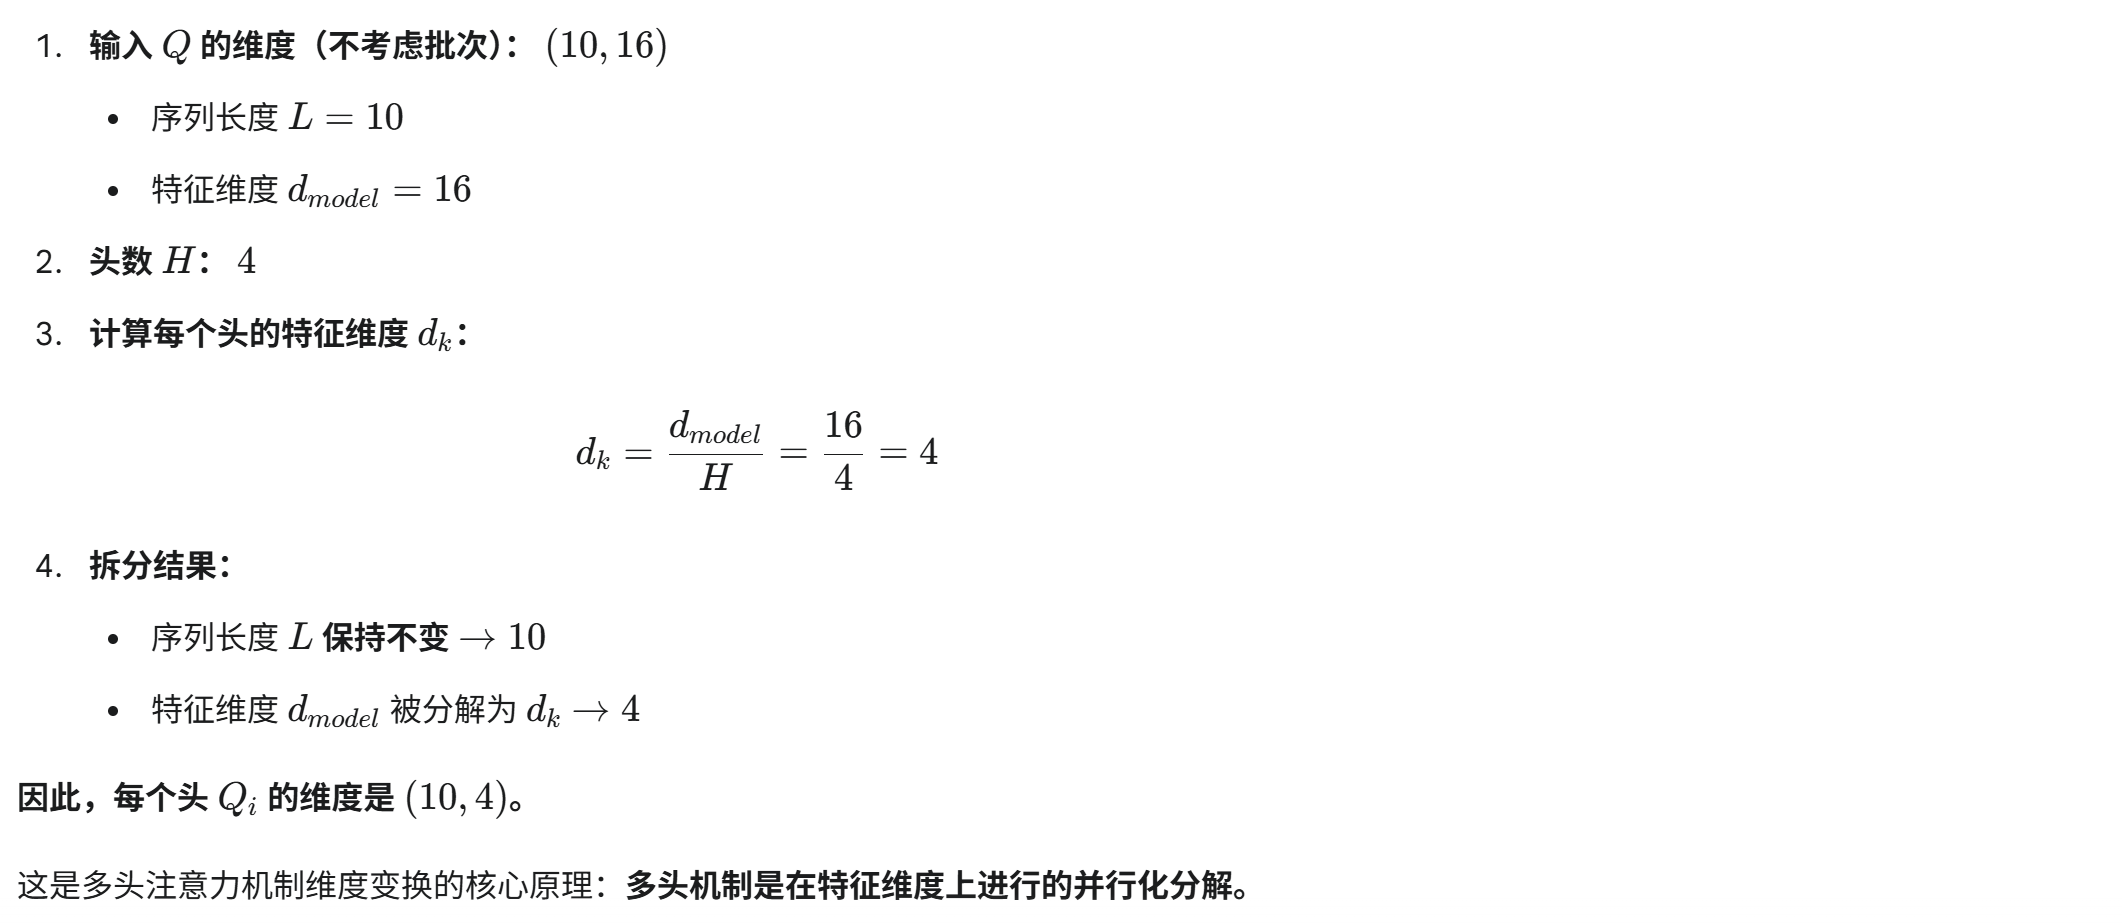  

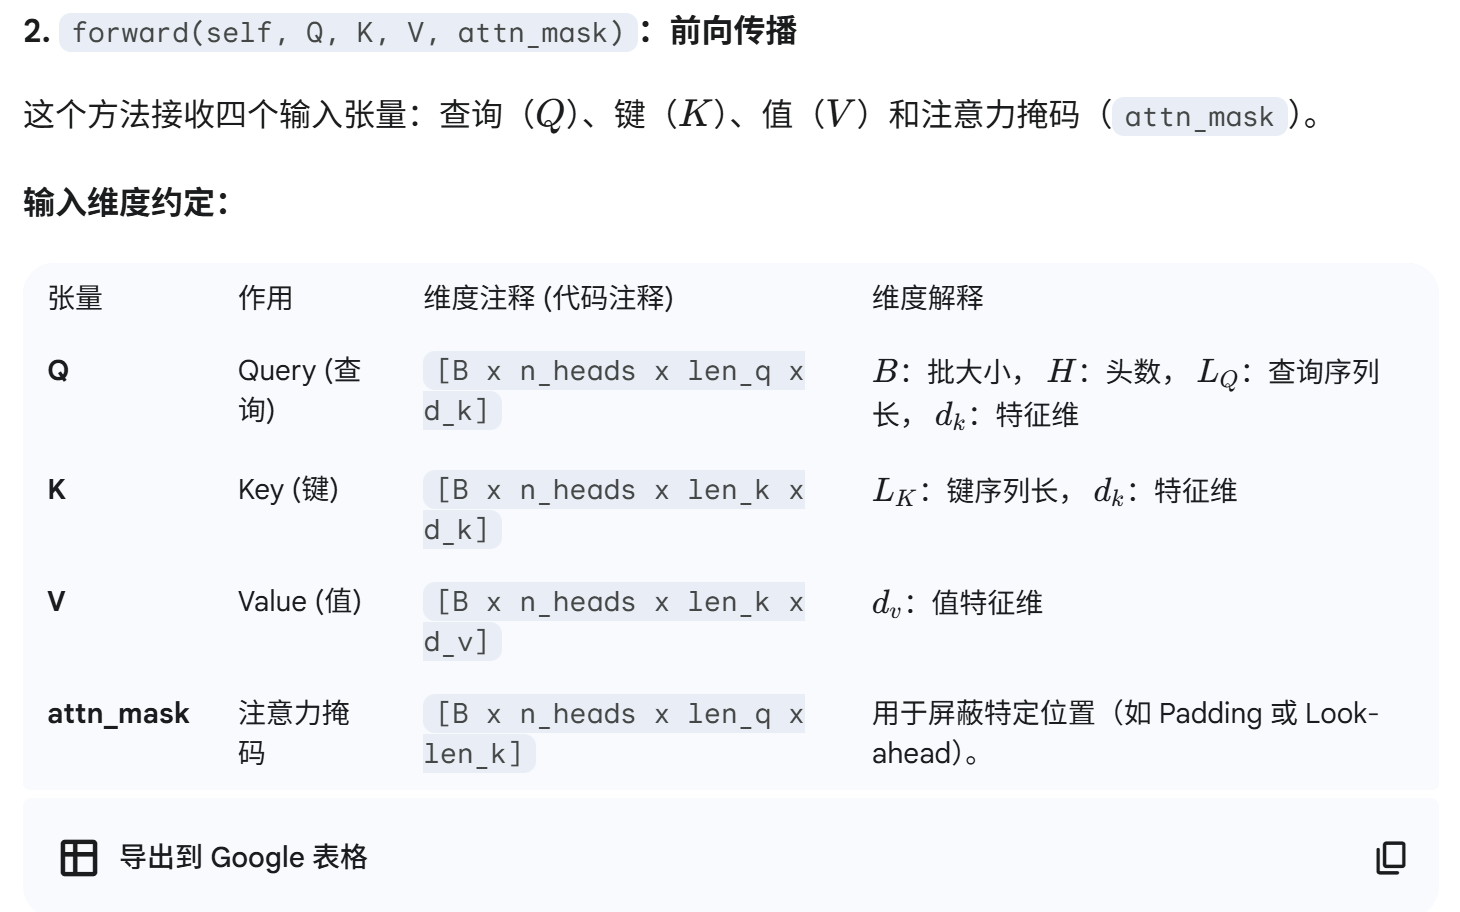

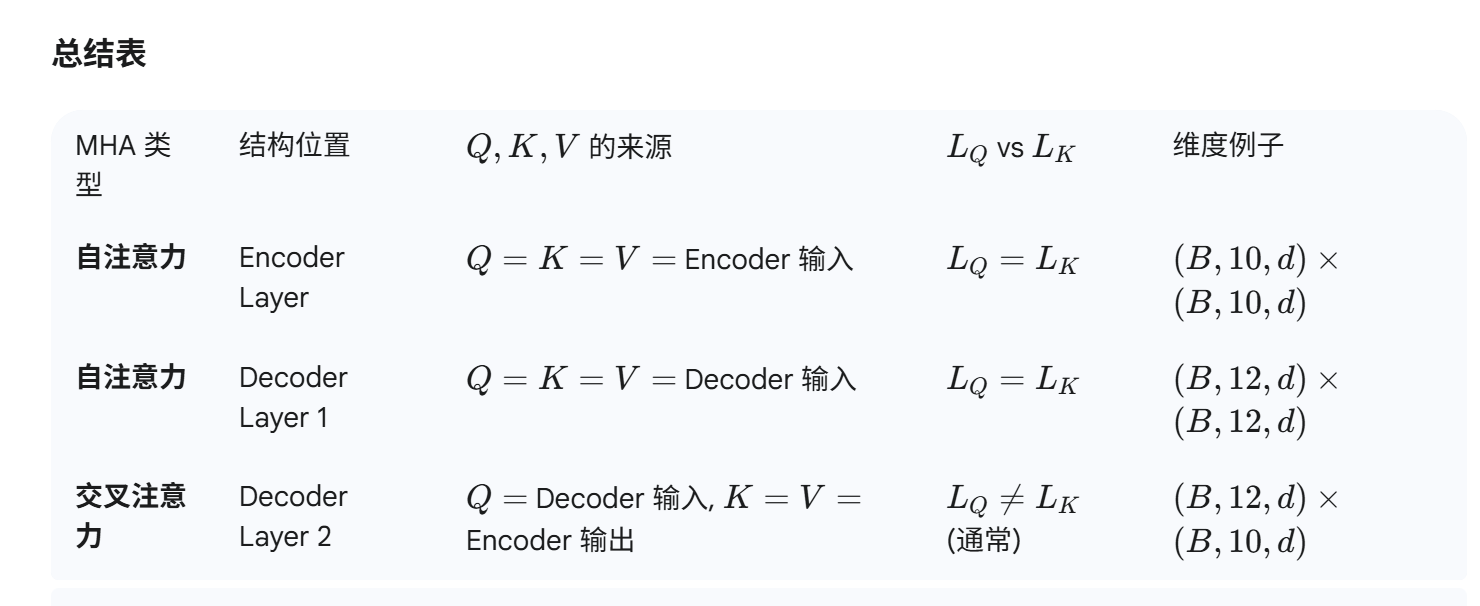

In [6]:
# ==============================================================================
# 2. 模型核心组件 (Core Modules)
# ==============================================================================

class ScaledDotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, d_k):
        #通过 super() 调用父类方法，你可以确保 ScaledDotProductAttention 类正常继承自 nn.Module，并能够使用 nn.Module 提供的功能，比如 .parameters()，.to()，.cuda() 等。
        super(ScaledDotProductAttention, self).__init__() # 调用父类 nn.Module 的 __init__() 方法。
        # 将 d_k 作为属性存储
        self.d_k = d_k

    def forward(self, Q, K, V, attn_mask):
        # Q, K, V: [B x n_heads x len_q(len_k) x d_k(d_v)]
        # Lq和Lk长度不一定相等。分自注意力机制还是交叉注意力机制。若是自注意力机制，序列中的每个元素都对序列自身进行查询 Q 和键 K。因此，输入 Q, K, V 都来自同一个序列。此时Lq=Lk
        # 在交叉注意力机制中， Lq 和 Lk 通常不相等。Q： 来自 Decoder 的输入，Lq=目标序列长度。K和V来自 Encoder 的最终输出， Lk =源序列长度
        # 示例：源句（德语）长度 L_K = 10。目标句（英语）长度 L_Q = 12。结果： L_Q 不等于 L_K。
        
        # 1. 计算 Scores: Q K^T / sqrt(d_k)
        
        # 通过矩阵相乘计算 Q 和 K^T 的点积，得到注意力得分（attention score）。这里 Q 和 K 的维度是 [B, n_heads, len_q(len_k), d_k]，所以计算结果 scores 的维度是 [B, n_heads, len_q, len_k]。
        # B 是批次大小（batch size）。n_heads 是注意力头的数量（head count）。len_q 是查询的长度（通常是解码器的序列长度，decoder input 的长度）。len_k 是键的长度（通常是编码器的序列长度，encoder output 的长度）。d_k 是每个头的查询和键的维度（通常是 d_model / n_heads）。
        # scores维度为(batch_size,n_heads,lenq,lenk)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k) # K.transpose(-1, -2)：键矩阵（Key）转置。
        
        # 2. Masking
        # Masking 值为 True 的位置被替换为极小值 (-1e9)
        scores.masked_fill_(attn_mask, -1e9) 
        
        # 3. Softmax
        attn = nn.Softmax(dim=-1)(scores)
        
        # 4. 加权求和
        # [... x len_q x len_k] × [... x len_k x d_v] -> [... x len_q x d_v]
        # 这是注意力机制的最终输出，它将值 V中包含的信息根据权重 attn 加权求和，生成一个包含了上下文依赖信息的上下文向量。
        context = torch.matmul(attn, V)
        # context: [B x n_heads x len_q x d_v]
        return context, attn # context：上下文向量，是注意力机制的输出。attn：注意力权重矩阵，用于可视化和分析。

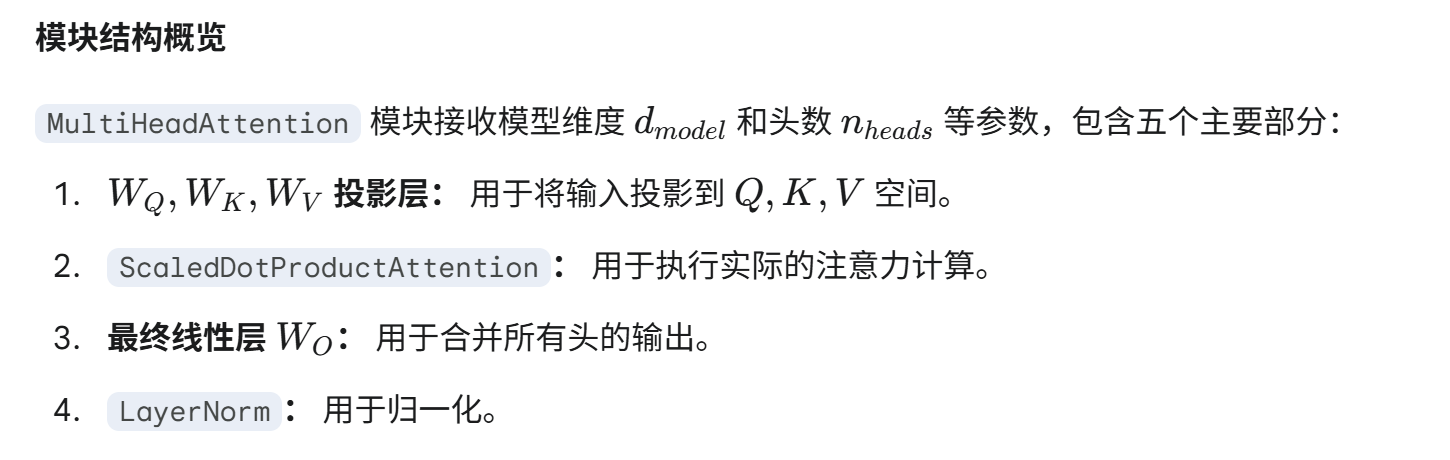

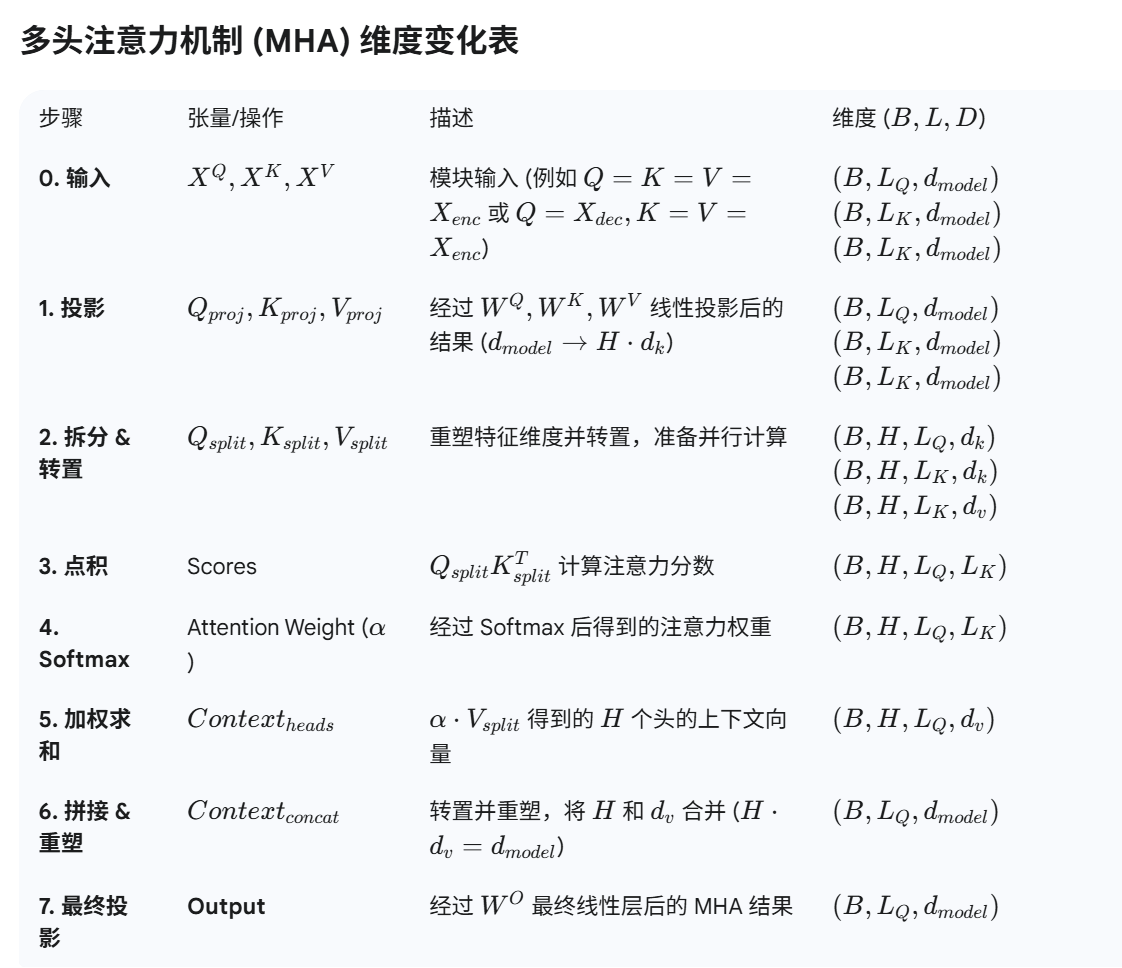

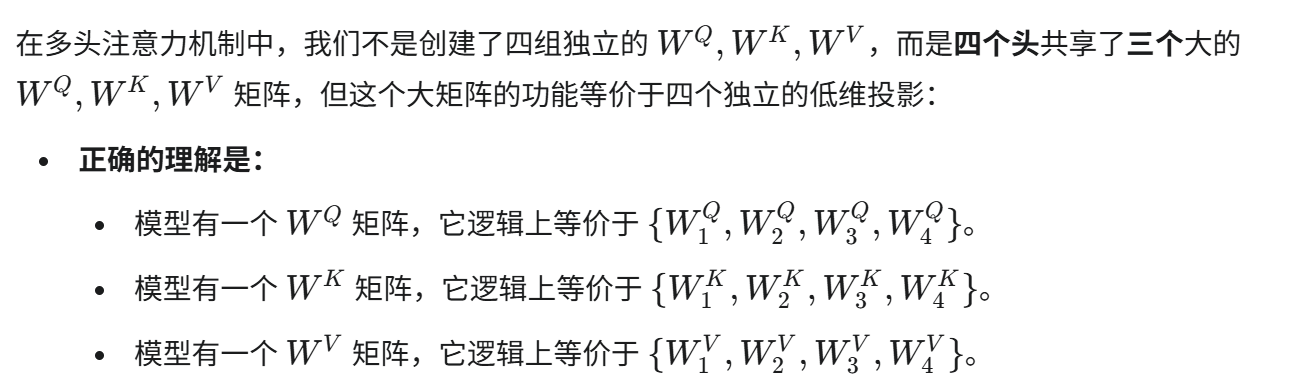

In [7]:
class MultiHeadAttention(nn.Module):
    """多头注意力 (参数规范化)"""
    def __init__(self, d_model, n_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model # 模型的特征维度
        self.n_heads = n_heads
        self.d_k = d_k #Transformer 中通常设置 d_k = d_v = d_model / n_heads。
        self.d_v = d_v
        
        # 投影层 W_Q, W_K, W_V
        # 由于在 Transformer 中通常设置 d_k = d_v = d_model/ n_heads，所以输出维度通常也等于 d_model
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False) # 实例化了一个 nn.Linear 对象，在内存中创建了 Wq 矩阵，并用随机数对其进行初始化。但：此时没有任何计算发生，也没有数据流入这个Wq矩阵。它只是一个待执行的数学操作和其参数的集合。
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        
        # 最终输出线性层 W_O
        # 用于学习如何最优地合并（聚合）来自所有 n_heads 的注意力结果，并输出 d_model 维度的特征。
        self.linear = nn.Linear(n_heads * d_v, d_model, bias=False)
        
        self.layer_norm = nn.LayerNorm(d_model)
        
        # 实例化 ScaledDotProductAttention
        self.attention = ScaledDotProductAttention(d_k)

    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)
        
        # 1. 线性投影 & 拆分多头 (Projection & Split)
        # (B, L, D_model) -> (B, L, N_heads * D_k) -> (B, L, N_heads, D_k) -> (B, N_heads, L, D_k)
        
        # 输入 Q, K, V： 维度均为 [batch_size, seq_len, d_model]
        # Q/K/V 投影 维度变化：[batch_size, seq_len, d_model] -> [batch_size, seq_len, n_heads * d_k]
        q_s = self.W_Q(Q) # 执行 X·Wq： 这行代码是真正执行线性变换的地方。 它将输入的张量Q（维度 [B, LenQ, d_model]）作为输入数据，与在 __init__ 中定义的权重矩阵 Wq（self.W_Q）进行矩阵乘法。
        k_s = self.W_K(K) # 执行 X·Wk
        v_s = self.W_V(V) # 执行 X·Wv
        
        # 重塑并转置 (Transpose)
        # view(batch_size, -1, self.n_heads, self.d_k):将特征维度 n_heads · d_k 分解成两个维度：n_heads 和 d_k。维度变化：[batch_size, seq_len, n_heads * d_k] -> [batch_sizeB, seq_len, n_heads, d_k]
        # 最终维度：[batch_size, n_heads, seq_len, d_k]。
        q_s = q_s.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) 
        k_s = k_s.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_s = v_s.view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)

        # 2. Mask 扩展到所有头
        # attn_mask: [B x 1 x Lenq x Lenk] -> [B x N_heads x Lenq x Lenk]
        # 注意: attn_mask 应该是 B x Lenq x Lenk，使用 unsqueeze(1) 增加 head 维度
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)

        # 3. 计算缩放点积注意力 (Scaled Dot-Product Attention)
        context, attn = self.attention(q_s, k_s, v_s, attn_mask)
        
        # 4. 拼接多头 (Concatenate) 相当于原来的d是512维，head如果是4的话，每个head的d就是128维。因此，q和k和v的维度从(batch_size,10,512) -> (batch_size,4,10,128)，attention计算返回的张量维度是(batch_size,4,10,128)，再进行拼接，即把4个128拼接在一起，形成(batch_size,10,512)
        # (B, N_heads, Lenq, d_v) -> (B, Lenq, N_heads, d_v) -> (B, Lenq, N_heads * d_v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        
        # 5. 最终线性层 W_O
        output = self.linear(context)
        
        # 6. 残差连接 + LayerNorm
        return self.layer_norm(output + residual), attn


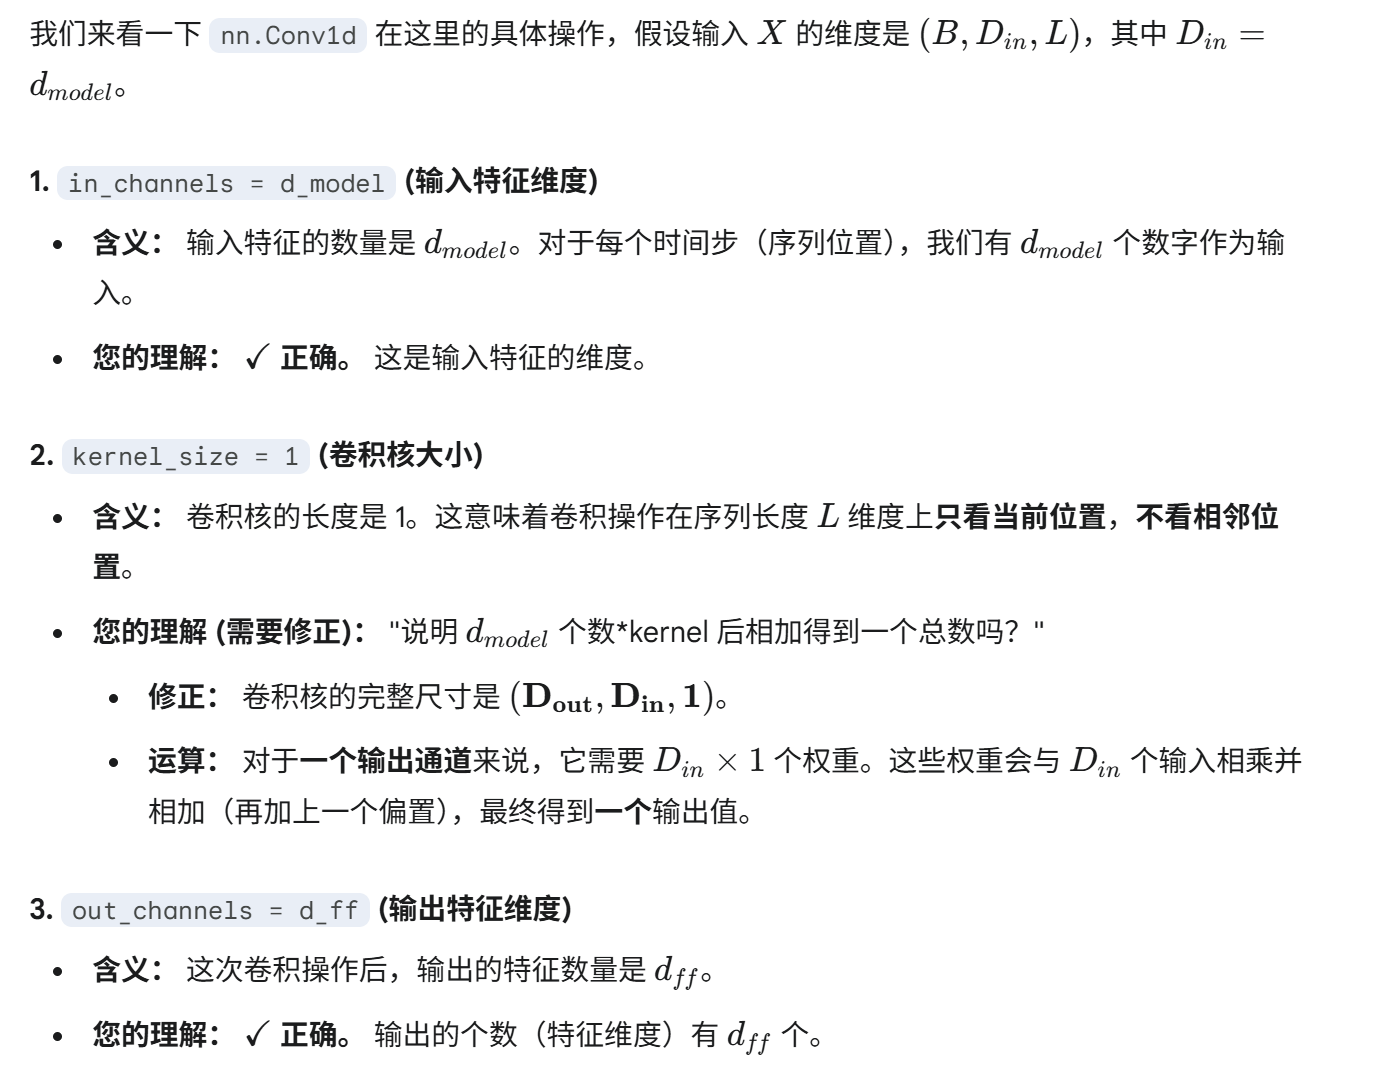

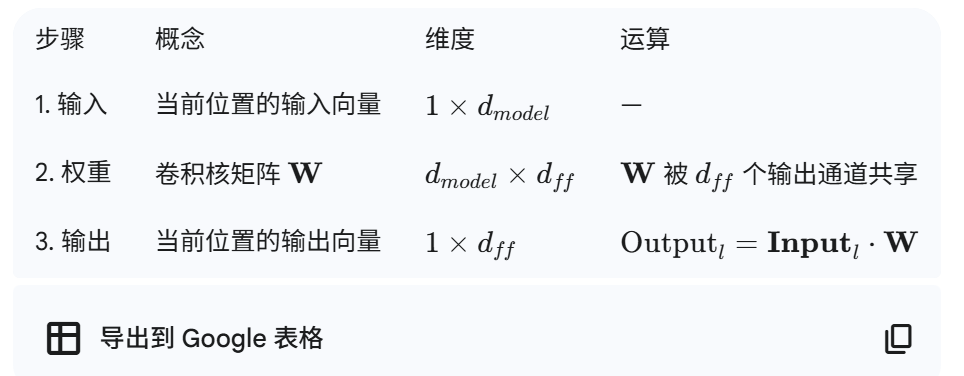

In [8]:
class PoswiseFeedForwardNet(nn.Module):
    """位置前馈网络 (参数规范化)"""
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        
        # 使用 nn.Linear 替代 Conv1D 更为常见和直观，这里保留 Conv1D 兼容原代码的实现方式。两个全连接层，一个全连接层把d_model缩放成d_ff个输出，然后第二个全连接层把d_ff个输出变成d_model个。
        # 输入的维度为(batch_size, d_model, len_q)，
        # 对于W_1层的 nn.Conv1d，其权重张量的维度是(d_ff, d_model, 1)。这表示它有d_ff 组独立的卷积核（即输出通道），每组卷积核的深度(通道数)与输入通道数d_model 相同，长度为 1。因此，每个输出通道在计算时，需要d_model×1个权重参数。总参数数量（不计偏置）为 d_ff × d_model。
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        
        # 1. 输入转置: (B, L, D) -> (B, D, L) 以适应 Conv1d
        # 2. Conv1d (线性扩展) -> ReLU
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        
        # 3. Conv2d (线性收缩)将高维信息投影回模型的标准维度，以便进行残差连接。
        output = self.conv2(output)
        
        # 4. 输出转置: (B, D, L) -> (B, L, D)
        output = output.transpose(1, 2)
        
        # 5. 残差连接 + LayerNorm
        return self.layer_norm(output + residual)


In [9]:
# ==============================================================================
# 3. 编码器与解码器层 (Layer Modules)
# ==============================================================================

class EncoderLayer(nn.Module):
    """编码器层 (参数规范化)"""
    def __init__(self, d_model, n_heads, d_k, d_v, d_ff):
        super(EncoderLayer, self).__init__()
        # 多头自注意力（Multi-Head Self-Attention）
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads, d_k, d_v)
        # 位置前馈网络（Position-wise Feed-Forward Network, FFN）
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        # 自注意力 (Self-Attention): Q=K=V=enc_inputs
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        
        # 前馈网络
        enc_outputs = self.pos_ffn(enc_outputs)
        
        return enc_outputs, attn

In [10]:
class DecoderLayer(nn.Module):
    """解码器层 (参数规范化)"""
    def __init__(self, d_model, n_heads, d_k, d_v, d_ff):
        super(DecoderLayer, self).__init__()
        # 1. Masked Self-Attention Masked 自注意力：让解码器的输入序列关注自身，但屏蔽未来信息。
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads, d_k, d_v)
        # 2. Encoder-Decoder Attention (Cross-Attention) 交叉注意力：让解码器的输出查询（Query）编码器的输出（Key 和 Value），实现序列间的依赖建模。
        self.dec_enc_attn = MultiHeadAttention(d_model, n_heads, d_k, d_v)
        # 3. FFN
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        # 1. Masked Self-Attention 
        # dec_self_attn_mask：1、Padding Mask： 屏蔽填充词。 2、Look-Ahead Mask(未来信息屏蔽)：这是解码器特有的。它确保在生成当前位置的词时，不能看到序列中未来的词语。这保证了模型在训练和推理时都遵循严格的顺序生成，维持了自回归特性。
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask) # 得到捕捉了上下文依赖，且只依赖于过去信息的 dec_outputs
        
        # 2. Encoder-Decoder Attention: Q=dec_outputs, K=V=enc_outputs
        # dec_enc_attn_mask：这通常是一个 Padding Mask，用于屏蔽编码器输出中可能存在的填充部分。
        # 作用： Decoded 序列中的每个词 (Q) 都会去查询整个 Encoded 序列 (K, V) 中最相关的信息，建立翻译/对齐关系。
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        
        # 3. FFN
        dec_outputs = self.pos_ffn(dec_outputs)
        
        return dec_outputs, dec_self_attn, dec_enc_attn

In [11]:
# ==============================================================================
# 4. 编码器与解码器 (Encoder & Decoder)
# ==============================================================================

class Encoder(nn.Module):
    """编码器 (参数规范化，修复位置编码索引问题)"""
    def __init__(self, src_vocab_size, d_model, n_layers, src_len, n_heads, d_k, d_v, d_ff):
        super(Encoder, self).__init__()
        self.src_len = src_len
        self.pad_id = PAD_ID # 假设 PAD_ID 已定义

        # 词嵌入，将词 ID 映射为 d_model 维度的语义向量（可训练参数）。
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        
        # 位置嵌入 (从预计算的正弦表中加载，冻结参数)
        sinusoid_table = get_sinusoid_encoding_table(src_len + 1, d_model)
        # 将这些数据注册为 PyTorch 模型的可查找组件。创建一个 nn.Embedding 模块，并将 sinusoid_table 中的数据作为该模块的初始权重。通过将其赋值给 self.pos_emb，它成为了 Encoder 模块的一个子模块
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
        
        # 编码器层堆叠
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_k, d_v, d_ff) for _ in range(n_layers)
        ])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        # 1. 词嵌入 + 位置编码
        # 注意: 动态生成位置索引 [1, 2, ..., L] 
        batch_size, seq_len = enc_inputs.size()
        pos_indices = torch.arange(seq_len, device=enc_inputs.device).unsqueeze(0).repeat(batch_size, 1) + 1
        
        # 将词嵌入和对应位置的位置编码简单相加
        #  self.src_emb(enc_inputs) : 根据 enc_inputs 中的每一个词汇 ID，到 self.src_emb 这个大表中找到对应的、长度为d_model 的向量，从而将离散的词 ID 转换为连续的、可训练的语义向量。
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(pos_indices)
        
        # 2. 生成 Pad Mask
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs, self.pad_id)
        
        # 3. 堆叠 N 个 Encoder Layer
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
            
        return enc_outputs, enc_self_attns
    

In [12]:
class Decoder(nn.Module):
    """解码器 (参数规范化，修复位置编码索引问题)"""
    def __init__(self, tgt_vocab_size, d_model, n_layers, tgt_len, n_heads, d_k, d_v, d_ff):
        super(Decoder, self).__init__()
        self.tgt_len = tgt_len
        self.pad_id = PAD_ID

        # 词嵌入
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        
        # 位置嵌入
        sinusoid_table = get_sinusoid_encoding_table(tgt_len + 1, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
        
        # 解码器层堆叠
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_k, d_v, d_ff) for _ in range(n_layers)
        ])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        '''
        在只考虑单头的情况下。首先，decoder的self_attention层，mask的维度是(batch_size, dec_inputs,dec_inputs)，是pad_mask+forward_mask。
        他所起到的作用是在自注意力机制层，在QKT后得到的维度为（batch_size, dec_inputs,dec_inputs)后的矩阵中，把应该mask掉的值替换成极小值。
        自注意力层输出的张量维度为（batch_size,dec_inputs,d_model)。这个张量作为Q进入cross_attention层。此时，encoder的输出作为K和V，其维度为(batch_size, enc_inputs,d_model)。
        Q_dec和K_enc作运算后，得到的张量维度是(batch_size,dec_inputs,enc_inputs),此时Dec-Enc Cross-Attention Mask的维度是(batch_size,dec_inputs,enc_inputs)，
        对极小值进行替换后，与V_enc进行运算，得到输出的张量维度为(batch_size, dec_inputs,d_model)。然后进入全连接层。
        '''
        # 1. 词嵌入 + 位置编码
        batch_size, seq_len = dec_inputs.size()
        # 动态生成位置索引
        pos_indices = torch.arange(seq_len, device=dec_inputs.device).unsqueeze(0).repeat(batch_size, 1) + 1
        
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos_indices)
        
        # 2. 生成 Dec Self-Attention Mask
        # Pad Mask
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.pad_id)
        # Look-ahead (Subsequent) Mask
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        # 组合 Mask: True 处被屏蔽：torch.gt(A, B)： 是 PyTorch 的 "Greater Than" 函数，比较张量 A 中的每个元素是否大于 B。如果大于，返回 True；否则返回 False。
        # 只有当一个位置既不是填充（Pad），也不是位于当前词的未来时，dec_self_attn_mask 在该位置的值才为 False（即不被屏蔽），允许注意力计算。
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        # 3. 生成 Dec-Enc Cross-Attention Mask
        # Q 是 Decoder 输入，K 是 Encoder 输入，只需要对 Encoder 的 Pad 进行 Mask
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.pad_id)

        # 4. 堆叠 N 个 Decoder Layer
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(
                dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask
            )
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
            
        return dec_outputs, dec_self_attns, dec_enc_attns

In [13]:
# ==============================================================================
# 5. Transformer 模型 (Transformer Model)
# ==============================================================================

class Transformer(nn.Module):
    """Transformer 整体模型 (参数规范化)"""
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, n_layers, src_len, tgt_len, n_heads, d_k, d_v, d_ff):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_layers, src_len, n_heads, d_k, d_v, d_ff)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_layers, tgt_len, n_heads, d_k, d_v, d_ff)
        # 最终的分类层
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
        
    def forward(self, enc_inputs, dec_inputs):
        # enc_inputs: [B x L_s]
        # dec_inputs: [B x L_t]
        
        # 1. 编码
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        
        # 2. 解码
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        
        # 3. 最终投影
        # dec_outputs: [B x L_t x d_model] -> dec_logits: [B x L_t x tgt_vocab_size]
        dec_logits = self.projection(dec_outputs) 
        
        # 为了计算损失函数，将结果重塑为 [ (B * L_t) x tgt_vocab_size ] ，[B, L_t, V] -> [(B * L_t), V]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [14]:
# ==============================================================================
# 6. 执行部分 (Execution Block)
# ==============================================================================

def showgraph(attn, sentences):
    """可视化注意力图"""
    # 假设 attn 是最后一层的一个头的注意力矩阵 [B x N_heads x L_q x L_k]
    # 取 B=0, N_heads=0, Squeeze(0)
    attn = attn[-1].squeeze(0)[0].data.cpu().numpy()
    
    # 确定标签 (假设句子已定义)
    src_labels = [''] + sentences[0].split()
    tgt_labels = [''] + sentences[2].split()

    fig = plt.figure(figsize=(N_HEADS, N_HEADS)) 
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    
    ax.set_xticklabels(src_labels, fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(tgt_labels, fontdict={'fontsize': 14})
    plt.show()

In [26]:
if __name__ == '__main__':
    # 示例数据
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    # 词汇表 (与代码开头保持一致)
    src_vocab = SRC_VOCAB
    tgt_vocab = TGT_VOCAB
    # 0: 'P' (索引 -> 词汇) 1: 'i'  2: 'want'
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    
    # 参数 (与代码开头保持一致)
    src_vocab_size = SRC_VOCAB_SIZE
    tgt_vocab_size = TGT_VOCAB_SIZE
    src_len = SRC_LEN
    tgt_len = TGT_LEN
    d_model = D_MODEL
    d_ff = D_FF
    d_k = D_K
    d_v = D_V
    n_layers = N_LAYERS
    n_heads = N_HEADS

    # 实例化模型，传入所有参数
    model = Transformer(
        src_vocab_size, tgt_vocab_size, d_model, n_layers, src_len, tgt_len, n_heads, d_k, d_v, d_ff
    )
    
    # 检查是否有GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    enc_inputs, dec_inputs, target_batch = make_batch(sentences, src_vocab, tgt_vocab)
    
    # 将数据移动到设备
    enc_inputs = enc_inputs.to(device)
    dec_inputs = dec_inputs.to(device)
    target_batch = target_batch.to(device)

    # 训练循环 (保持原逻辑)
    for epoch in range(20):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        # outputs 的维度是 [(Batch Size * Target Sequence Length), Target Vocab Size]。每一行代表目标序列中一个位置的词汇预测分数
        # .contiguous()： 这是一个内存操作。contiguous() 方法确保张量在内存中是连续的，这是后续 view() 操作所要求的。
        # .view(-1)： 这是关键的维度重塑操作。它将 [Batch Size, Target Sequence Length] 的二维张量展平成一个一维张量。最终维度是 [(Batch Size * Target Sequence Length)]。它包含目标序列中所有词汇 ID 的列表，按顺序排列。
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss.item()))
        loss.backward()
        optimizer.step()

    # 测试
    model.eval() # 将模型设置为 评估模式（Evaluation Mode）。1、冻结参数 2、关闭 Dropout 3、固定 BatchNorm（使用训练阶段计算得到的平均值和方差统计信息）
    with torch.no_grad():
        predict, _, _, _ = model(enc_inputs, dec_inputs)
    
    # 预测结果
    predict = predict.data.max(1, keepdim=True)[1]
    predicted_tokens = [number_dict[n.item()] for n in predict.squeeze().cpu()]
    
    print('-' * 30)
    print(sentences[0], '->', ' '.join(predicted_tokens))

    # 可视化 (原代码中 showgraph 的实现有问题，可能无法正确显示，但这里保留了调用)
    # 注意：为了让 plt.show() 工作，需要在没有交互环境时注释掉或在交互式环境中运行。
    print('\nfirst head of last state enc_self_attns')
    # showgraph(enc_self_attns, sentences) 

    print('first head of last state dec_self_attns')
    # showgraph(dec_self_attns, sentences) 

    print('first head of last state dec_enc_attns')
    # showgraph(dec_enc_attns, sentences)

Epoch: 0001 cost = 1.977670
Epoch: 0002 cost = 0.898374
Epoch: 0003 cost = 2.320863
Epoch: 0004 cost = 3.651262
Epoch: 0005 cost = 4.541877
Epoch: 0006 cost = 5.101392
Epoch: 0007 cost = 6.228414
Epoch: 0008 cost = 2.625271
Epoch: 0009 cost = 2.721785
Epoch: 0010 cost = 2.522199
Epoch: 0011 cost = 2.154632
Epoch: 0012 cost = 1.860019
Epoch: 0013 cost = 1.808966
Epoch: 0014 cost = 1.839336
Epoch: 0015 cost = 1.784837
Epoch: 0016 cost = 1.751433
Epoch: 0017 cost = 1.751194
Epoch: 0018 cost = 1.724355
Epoch: 0019 cost = 1.684696
Epoch: 0020 cost = 1.665385
------------------------------
ich mochte ein bier P -> E E E E E

first head of last state enc_self_attns
first head of last state dec_self_attns
first head of last state dec_enc_attns


In [ ]:
sentences = [['ich mochte ein bier P'] * 100,['S i want a beer'] * 100,['i want a beer E']*100] 


100